<a href="https://colab.research.google.com/github/ankit-singh973/Deep_Learning/blob/main/1_3_PyTorch_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural network classification with PyTorch**

## 1. **Make classification data and get it ready**

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

#create circles
X,y = make_circles(n_samples,
                   noise = 0.03,
                   random_state = 42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 smaples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 smaples of y:
 [1 1 1 1 0]


In [5]:
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


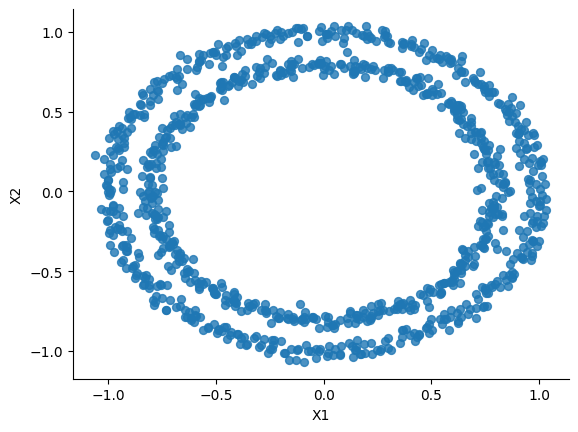

In [6]:
# @title X1 vs X2

from matplotlib import pyplot as plt
circles.plot(kind='scatter', x='X1', y='X2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

### **Visualize**

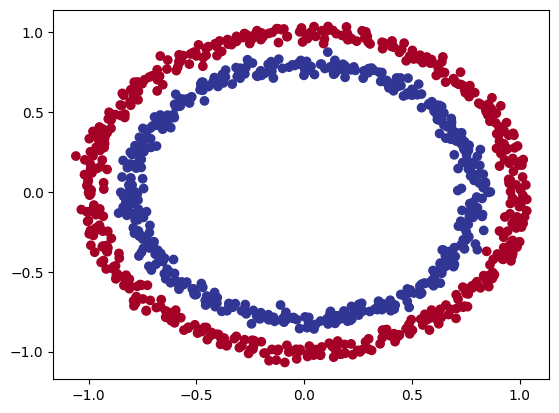

In [7]:
import matplotlib.pyplot as plt

plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu);

In [8]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# Check input and output shapes

X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [10]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [11]:
# Split data into traain test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,
                                                    random_state = 42)

### **Building a Model**

1. Setup device agnostic code, so our code will run on GPU if there is available
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [12]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
# !. construct a model that inherits subclass nn.Module

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        # 2. Create nn.Layers capable of handling the shape of our data (i.e input features)
        self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
        self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

    # 3. Define a forward method
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
next(model_0.parameters()).device

device(type='cuda', index=0)

### **Let's replicate the above model by `nn.Sequential()`**

In [15]:
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2834, -0.1019],
                      [ 0.2254, -0.3780],
                      [ 0.2253, -0.2986],
                      [-0.0727, -0.2919],
                      [-0.3906, -0.3855]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6026,  0.4774, -0.0056,  0.3629, -0.4838], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.3955,  0.2438, -0.2924,  0.4099, -0.0052]], device='cuda:0')),
             ('1.bias', tensor([-0.1250], device='cuda:0'))])

In [17]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

print(f"First 10 predictions : \n {torch.round(untrained_preds[:10])}")
print(f"First 10 labels: \n {y_test[:10]}")

First 10 predictions : 
 tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [0.],
        [0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]], device='cuda:0')
First 10 labels: 
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


- This is very bad classification prediction

## **2.1 Setup loss function and optimizer**
* We've setup a loss (also called a criterion or cost function) and optimizer.

* But different problem types require different loss functions.

* For example, for a regression problem (predicting a number) we have used mean absolute error (MAE) loss.

* And for a binary classification problem (like ours), we'll often use binary cross entropy as the loss function.

* However, the same optimizer function can often be used across different problem spaces.

* For example, the stochastic gradient descent optimizer (SGD, torch.optim.SGD()) can be used for a range of problems, and the same applies to the Adam optimizer (torch.optim.Adam()).


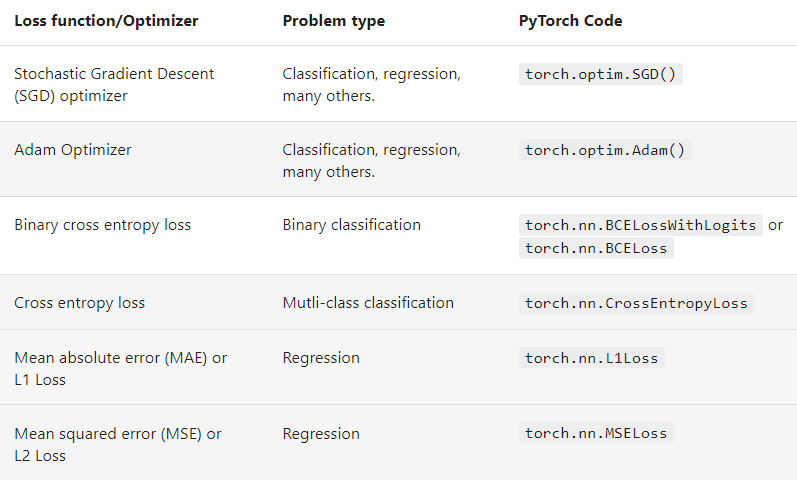

### **Logits layer**
* The layer that feeds in to softmax( or other such as normalization) is k/a logits layer.
* The output of the softmax are the probablities for the classification task and its input is logits layer.

In [18]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [19]:
# calculate accuracy

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## **3. Model Training**
To train our model, we need to build training loop with following steps:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backwards (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels

In [20]:
# view the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2327],
        [-0.2492],
        [-0.0943],
        [-0.2723],
        [ 0.0567]], device='cuda:0')

In [21]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [22]:
# Use the sigmoid activation function on our model logits to turn them into prediction probablities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4421],
        [0.4380],
        [0.4764],
        [0.4323],
        [0.5142]], device='cuda:0')

In [23]:
# Find predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 1.], device='cuda:0')

### **3.2 Building a Training and Testing loop**

In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ## Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss/accuracy
    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)

    # 3. Optimizer
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        #1. forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. calc test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"epoch {epoch} | Loss: {acc:.2f}% | Test Loss: {test_loss: .5f}, Test acc: {test_acc:.2f}%")

epoch 0 | Loss: 46.50% | Test Loss:  0.69324, Test acc: 48.50%
epoch 10 | Loss: 47.75% | Test Loss:  0.69252, Test acc: 52.00%
epoch 20 | Loss: 48.50% | Test Loss:  0.69234, Test acc: 52.00%
epoch 30 | Loss: 49.25% | Test Loss:  0.69235, Test acc: 50.00%
epoch 40 | Loss: 49.25% | Test Loss:  0.69242, Test acc: 50.50%
epoch 50 | Loss: 49.00% | Test Loss:  0.69252, Test acc: 51.00%
epoch 60 | Loss: 49.38% | Test Loss:  0.69264, Test acc: 50.00%
epoch 70 | Loss: 50.00% | Test Loss:  0.69275, Test acc: 49.00%
epoch 80 | Loss: 50.38% | Test Loss:  0.69287, Test acc: 49.00%
epoch 90 | Loss: 50.12% | Test Loss:  0.69299, Test acc: 47.50%


## **4. Make predictions and evaluate the model**
* From the metrics it looks like our model is not learning anything....
* So to inspect it let's make some predictions and visualize it,


In [25]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

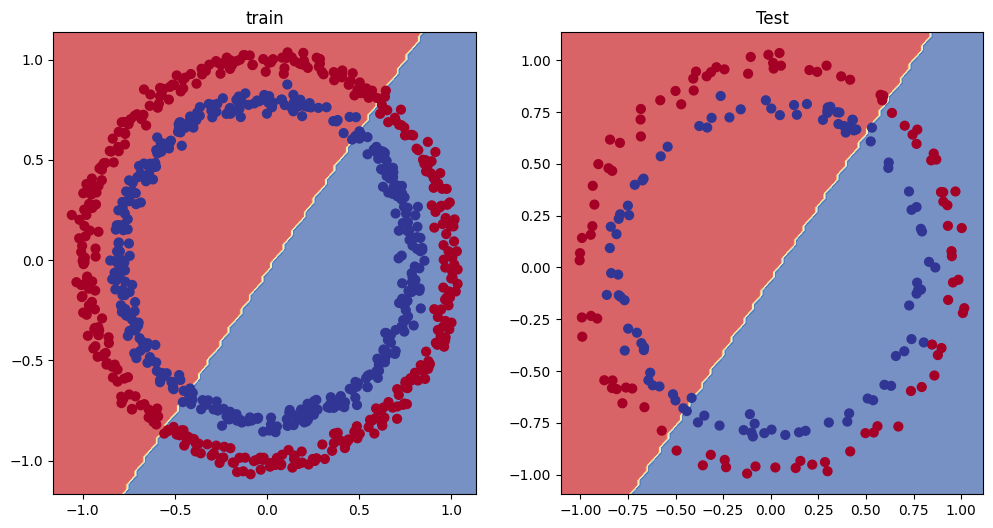

In [26]:
# Plot decision boundary of model
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1) # index of graph
plt.title("train")
plot_decision_boundary(model_0, X_train, y_train)
#
plt.subplot(1, 2, 2) #index of graph
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

* It seems like we've found the cause of model's performance issue.

* It's currently trying to split the red and blue dots using a straight line...

* That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.

* In machine learning terms, our model is underfitting, meaning it's not learning predictive patterns from the data.

    > How could we improve this?

## **MOdel Improvement**

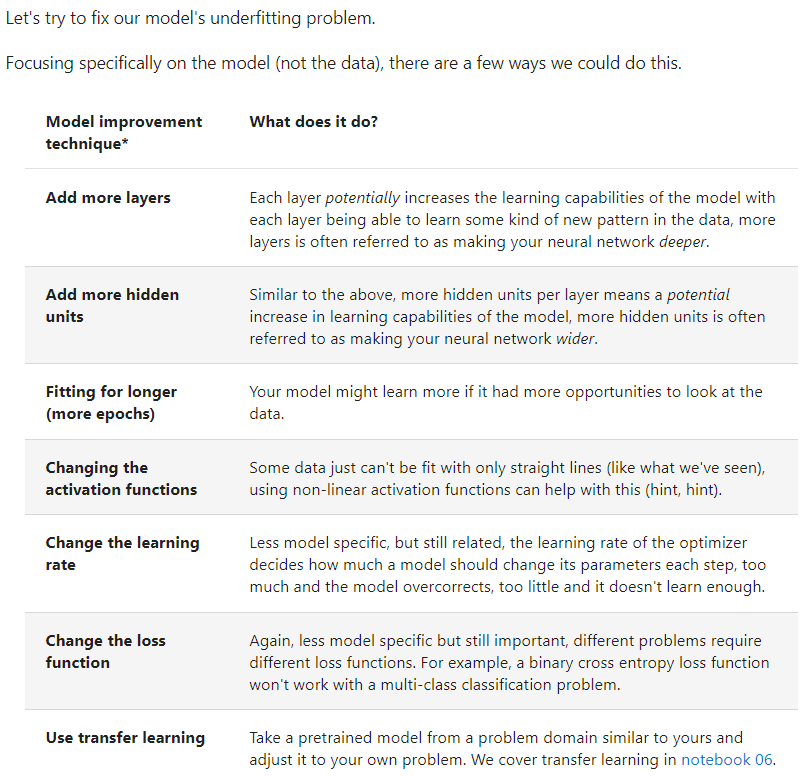

In [27]:
# Let's make a new model
'''adding more hidden units: 5 --> 10'''

class CircleModelv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelv1().to(device)
model_1

CircleModelv1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [28]:
# loss function
loss_fn = nn.BCEWithLogitsLoss()

# create an optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer time
epochs = 1000

#put the data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

    # Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calc the loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards (backward propagation)
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():

        # 1. forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calc loss
        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)

    # Print out what's happenin'
    if epoch % 100 == 0:
        print(f"epoch {epoch} | Loss: {acc:.2f}% | Test Loss: {test_loss: .5f}, Test acc: {test_acc:.2f}%")

epoch 0 | Loss: 50.88% | Test Loss:  0.69261, Test acc: 51.00%
epoch 100 | Loss: 50.38% | Test Loss:  0.69379, Test acc: 48.00%
epoch 200 | Loss: 51.12% | Test Loss:  0.69437, Test acc: 46.00%
epoch 300 | Loss: 51.62% | Test Loss:  0.69458, Test acc: 45.00%
epoch 400 | Loss: 51.12% | Test Loss:  0.69465, Test acc: 46.00%
epoch 500 | Loss: 51.00% | Test Loss:  0.69467, Test acc: 46.00%
epoch 600 | Loss: 51.00% | Test Loss:  0.69468, Test acc: 46.00%
epoch 700 | Loss: 51.00% | Test Loss:  0.69468, Test acc: 46.00%
epoch 800 | Loss: 51.00% | Test Loss:  0.69468, Test acc: 46.00%
epoch 900 | Loss: 51.00% | Test Loss:  0.69468, Test acc: 46.00%


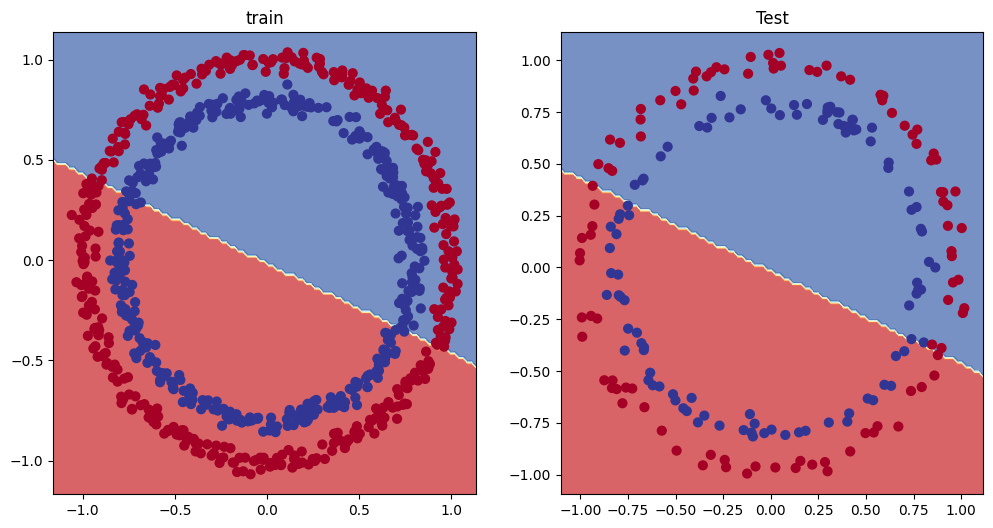

In [30]:
# Plot decision boundary of model
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1) # index of graph
plt.title("train")
plot_decision_boundary(model_1, X_train, y_train)
#
plt.subplot(1, 2, 2) #index of graph
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [31]:
# ADDING NON-LINEARITY TO OUR MODEL
# Let's make a new model
'''1. adding more hidden units: 5 --> 10
   2. adding non-linear activation function'''

class CircleModelv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
        self.relu = nn.ReLU() # non-linear activation function

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModelv2().to(device)
model_2

CircleModelv2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [32]:
# loss function
loss_fn = nn.BCEWithLogitsLoss()

# create an optimizer
optimizer = torch.optim.SGD(params = model_2.parameters(),
                            lr = 0.1)

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer time
epochs = 1000

# put the data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

    # Training
    model_2.train()

    # 1. Forward pass
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calc the loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards (backward propagation)
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():

        # 1. forward pass
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calc loss
        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)

    # Print out what's happenin'
    if epoch % 50 == 0:
        print(f"epoch {epoch} | Loss: {acc:.2f}% | Test Loss: {test_loss: .5f}, Test acc: {test_acc:.2f}%")

epoch 0 | Loss: 50.00% | Test Loss:  0.69319, Test acc: 50.00%
epoch 50 | Loss: 58.25% | Test Loss:  0.69177, Test acc: 58.00%
epoch 100 | Loss: 52.88% | Test Loss:  0.69102, Test acc: 52.50%
epoch 150 | Loss: 52.88% | Test Loss:  0.69027, Test acc: 55.00%
epoch 200 | Loss: 53.37% | Test Loss:  0.68940, Test acc: 55.00%
epoch 250 | Loss: 53.50% | Test Loss:  0.68840, Test acc: 56.00%
epoch 300 | Loss: 53.00% | Test Loss:  0.68723, Test acc: 56.00%
epoch 350 | Loss: 52.62% | Test Loss:  0.68587, Test acc: 56.50%
epoch 400 | Loss: 52.75% | Test Loss:  0.68411, Test acc: 56.50%
epoch 450 | Loss: 52.75% | Test Loss:  0.68198, Test acc: 56.00%
epoch 500 | Loss: 52.75% | Test Loss:  0.67941, Test acc: 56.50%
epoch 550 | Loss: 53.37% | Test Loss:  0.67641, Test acc: 56.00%
epoch 600 | Loss: 54.50% | Test Loss:  0.67285, Test acc: 56.00%
epoch 650 | Loss: 56.12% | Test Loss:  0.66852, Test acc: 57.00%
epoch 700 | Loss: 58.38% | Test Loss:  0.66322, Test acc: 59.00%
epoch 750 | Loss: 61.12% | T

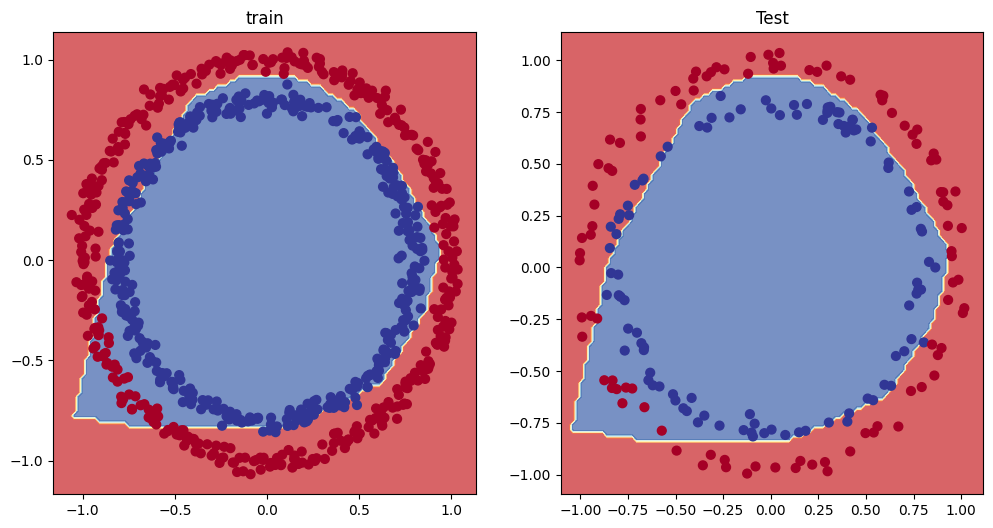

In [34]:
# Plot decision boundary of model
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1) # index of graph
plt.title("train")
plot_decision_boundary(model_2, X_train, y_train)
#
plt.subplot(1, 2, 2) #index of graph
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

In [35]:
# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# **Multiclass classification Problem**

### Creating a Toy dataset

tensor([[ -3.1987,   7.3945],
        [ -9.0976, -10.2246],
        [  5.5605,   2.5364],
        [ -8.1341,  -9.6798],
        [ -5.8277,  -5.7955]]) tensor([0, 2, 1, 2, 2])


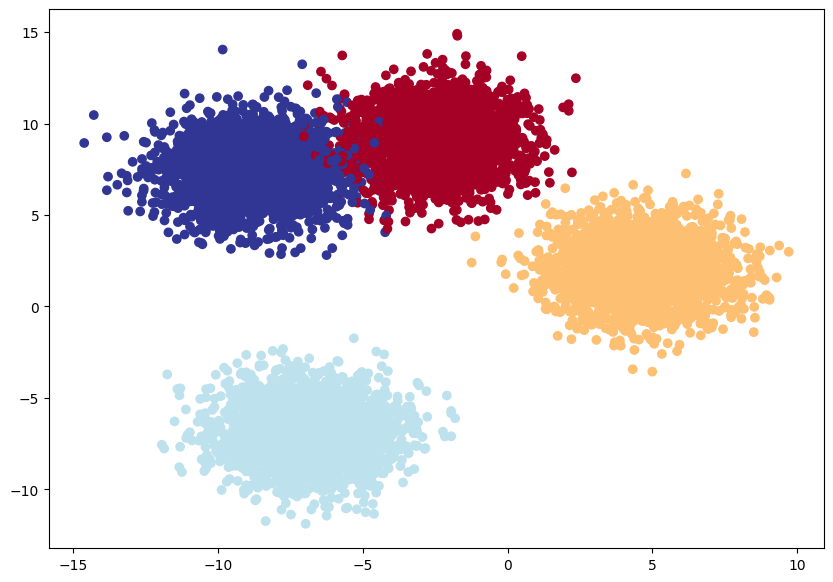

In [59]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 10000,
                           n_features = NUM_FEATURES,
                           centers = NUM_CLASSES,
                           cluster_std = 1.5,
                           random_state = RANDOM_SEED)

# 2. Trun data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Slpit into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = RANDOM_SEED)

# 4. Plot data (visualize)
plt.figure(figsize = (10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap = plt.cm.RdYlBu);

In [60]:
# setting up device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [84]:
# Build a muilti-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        '''Initialize multi-class classification'''
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

# create an instance of Blobmodel and send it to the target device
model_4 = BlobModel(input_features = NUM_FEATURES,
                   output_features = NUM_CLASSES,
                   hidden_units = 8).to(device)

model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [85]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([8000, 2]), tensor([0, 0, 3, 3, 2], device='cuda:0'))

In [86]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3], device='cuda:0')

## Creating a loss function and Optimizer

In [87]:
# Create a loss function
loss_fn = nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(params = model_4.parameters(),
                           lr = 0.1)

## Getting prediction probablities for a multi-class PyTorch model

In [88]:
model_4(X_blob_train.to(device))[:5]

tensor([[-0.3599, -1.4971, -1.2670, -0.3718],
        [-0.2468, -1.2474, -1.0060, -0.2984],
        [-0.0986, -0.9505, -0.5882, -0.1269],
        [-0.1407, -1.0368, -0.7023, -0.1710],
        [ 0.2509, -0.2392,  0.1830, -0.0028]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [89]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [90]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2548, -0.9130, -2.2454, -1.5358],
        [-0.6320, -0.6842, -1.2517, -0.8207],
        [-0.6838, -0.6438, -1.3876, -1.0143],
        [ 0.1771, -0.3625,  0.0150,  0.0327],
        [-0.2116, -1.1999, -0.8497, -0.2009]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.2830, 0.3983, 0.1051, 0.2137],
        [0.3016, 0.2863, 0.1623, 0.2498],
        [0.3073, 0.3198, 0.1520, 0.2208],
        [0.3031, 0.1767, 0.2578, 0.2624],
        [0.3435, 0.1279, 0.1815, 0.3472]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [91]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2830, 0.3983, 0.1051, 0.2137], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(1, device='cuda:0')


In [92]:
# Let's get some raw output of our model (logits)
model_4.eval()
with torch.inference_mode():
    y_preds = model_4(X_blob_test.to(device))

y_preds[:10]

tensor([[-1.2548, -0.9130, -2.2454, -1.5358],
        [-0.6320, -0.6842, -1.2517, -0.8207],
        [-0.6838, -0.6438, -1.3876, -1.0143],
        [ 0.1771, -0.3625,  0.0150,  0.0327],
        [-0.2116, -1.1999, -0.8497, -0.2009],
        [-1.1334, -0.8550, -2.0616, -1.4203],
        [-0.1742, -1.1061, -0.7913, -0.2044],
        [-0.4833, -0.5525, -1.0488, -0.7795],
        [-1.0296, -0.8075, -1.8815, -1.2902],
        [-0.9362, -0.7622, -1.7470, -1.2109]], device='cuda:0')

# **Convert our model's logit outputs to prediction probablities to prediction labels**

In [93]:
y_preds_probs = torch.softmax(y_logits, dim = 1)
print(y_logits[:5])
print(y_logits[:5])

tensor([[-1.2548, -0.9130, -2.2454, -1.5358],
        [-0.6320, -0.6842, -1.2517, -0.8207],
        [-0.6838, -0.6438, -1.3876, -1.0143],
        [ 0.1771, -0.3625,  0.0150,  0.0327],
        [-0.2116, -1.1999, -0.8497, -0.2009]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[-1.2548, -0.9130, -2.2454, -1.5358],
        [-0.6320, -0.6842, -1.2517, -0.8207],
        [-0.6838, -0.6438, -1.3876, -1.0143],
        [ 0.1771, -0.3625,  0.0150,  0.0327],
        [-0.2116, -1.1999, -0.8497, -0.2009]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [94]:
torch.sum(y_pred_probs[0])

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

In [95]:
y_preds = torch.argmax(y_pred_probs, dim=1)
print(y_preds)

tensor([1, 0, 1,  ..., 0, 0, 0], device='cuda:0')


In [96]:
y_blob_test

tensor([1, 1, 1,  ..., 3, 3, 0], device='cuda:0')

## **Create a training and testing loop for a multi-class PyTorch model**

In [97]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer time
epochs = 100

# put the data on the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):

    # Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim =1).argmax(dim = 1)

    # 2. Calc the loss/acc
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true = y_blob_train,
                      y_pred = y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards (backward propagation)
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():

        # 1. forward pass
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # 2. Calc loss
        test_loss = loss_fn(test_logits, y_blob_test)

        test_acc = accuracy_fn(y_true = y_blob_test,
                               y_pred = test_preds)

    # Print out what's happenin'
    if epoch % 10 == 0:
        print(f"epoch {epoch} | Loss: {acc:.2f}% | Test Loss: {test_loss: .2f}, Test acc: {test_acc:.2f}%")

epoch 0 | Loss: 38.05% | Test Loss:  1.07, Test acc: 55.85%
epoch 10 | Loss: 97.08% | Test Loss:  0.62, Test acc: 97.00%
epoch 20 | Loss: 98.52% | Test Loss:  0.40, Test acc: 98.15%
epoch 30 | Loss: 98.98% | Test Loss:  0.21, Test acc: 98.80%
epoch 40 | Loss: 99.00% | Test Loss:  0.10, Test acc: 98.80%
epoch 50 | Loss: 99.04% | Test Loss:  0.07, Test acc: 98.85%
epoch 60 | Loss: 99.05% | Test Loss:  0.05, Test acc: 98.80%
epoch 70 | Loss: 99.05% | Test Loss:  0.05, Test acc: 98.80%
epoch 80 | Loss: 99.08% | Test Loss:  0.04, Test acc: 98.75%
epoch 90 | Loss: 99.04% | Test Loss:  0.04, Test acc: 98.70%


## **making and evaluating predictions**

In [98]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ -2.6641,   9.4805,  -9.2195, -10.0745],
        [ -1.6550,   5.6671,  -4.8836,  -5.7481],
        [ -1.4283,   5.9959,  -6.1765,  -7.0119],
        [ -4.0351,  -4.7896,   2.8216,  -1.7435],
        [ -3.2488,  -8.6948,  -5.1557,   4.3238],
        [ -2.4259,   8.7443,  -8.5278,  -9.3831],
        [ -0.6604,  -6.5125,  -5.3030,   1.6917],
        [ -1.2370,   4.7341,  -4.5122,  -5.3879],
        [ -2.2592,   7.9935,  -7.5871,  -8.4466],
        [ -2.1073,   7.5014,  -7.1551,  -8.0232]], device='cuda:0')

In [99]:
# Go from logits --> prediction probablities
y_pred_probs = torch.softmax(y_logits, dim = 1)
y_pred_probs[:10]

tensor([[5.3172e-06, 9.9999e-01, 7.5630e-09, 3.2166e-09],
        [6.6030e-04, 9.9930e-01, 2.6156e-05, 1.1018e-05],
        [5.9629e-04, 9.9940e-01, 5.1680e-06, 2.2413e-06],
        [1.0399e-03, 4.8904e-04, 9.8819e-01, 1.0285e-02],
        [5.1408e-04, 2.2173e-06, 7.6357e-05, 9.9941e-01],
        [1.4087e-05, 9.9999e-01, 3.1535e-08, 1.3408e-08],
        [8.6802e-02, 2.4947e-04, 8.3609e-04, 9.1211e-01],
        [2.5448e-03, 9.9732e-01, 9.6214e-05, 4.0079e-05],
        [3.5262e-05, 9.9996e-01, 1.7118e-07, 7.2470e-08],
        [6.7141e-05, 9.9993e-01, 4.3125e-07, 1.8103e-07]], device='cuda:0')

In [100]:
# Go from prediction probablities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim =1)
y_preds[:10]

tensor([1, 1, 1, 2, 3, 1, 3, 1, 1, 1], device='cuda:0')

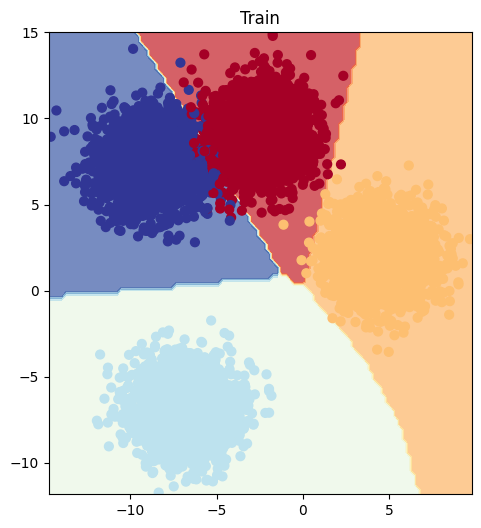

In [101]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

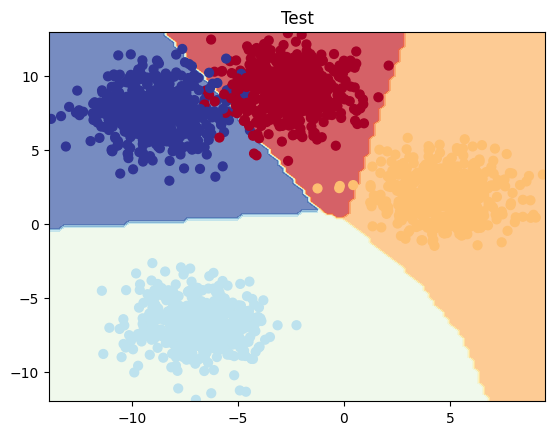

In [102]:
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# **Classification Metrics**
* Accuracy
* Precision
* F1 - Score
* Confusion matrix
* Classification report

In [103]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [104]:
from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9870, device='cuda:0')

In [105]:
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9870, device='cuda:0')